Instructions for setting up conda kernel on NCAR machine:  
- open terminal (e.g., in JupyterHub)
- execute the following series of commands:

`module load conda`  
`conda create -n shap`  
`conda activate shap`  
`conda install shap pandas scikit-learn matplotlib numpy ipykernel jupyter ipywidgets`  

- now you should see a [conda-env:shap] conda kernel available when you open a jupyter notebook

In [1]:
import pandas as pd
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import shap
import seaborn as sns
import pickle
import random

# Data processing

In [2]:
# load data
filepath = '/glade/work/psturm/ice-mp-su24/saved_trajectory_data/trajs_5100_7200_Ns10000.csv' # obin's latest csv with combined data
df = pd.read_csv(filepath)
# sort df
sort_cols = ['time', 'rk_deact']
df_sort = df.sort_values(by=sort_cols)
df_sort['volume[m3]'] = (4/3)*np.pi*(df_sort['radius_eq(ice)[m]'])**3
df_sort['mass[kg]'] = df_sort['volume[m3]']*df_sort['density(droplet/ice)[kg/m3]']
# df of current timestep
df1 = df_sort 
n_unique_ids = len(df1['rk_deact'].unique())
len_df = len(df1) - n_unique_ids
df1 = df_sort[:len_df]
df1.reset_index(inplace=True)
# df of next timestep
df2 = df_sort
df2 = df2[n_unique_ids:]
df2.reset_index(inplace=True)
# join dataframes
df = df1.join(df2, lsuffix='_1', rsuffix='_2')
df['delta_mass'] = df['mass[kg]_2'] - df['mass[kg]_1'] # add change in mass
df['delta_r'] = df['radius_eq(ice)[m]_2'] - df['radius_eq(ice)[m]_1'] # add change in radius
# split into training and test data
ids = df['rk_deact_1'].unique()
ids_train, ids_test = train_test_split(ids, test_size=0.2, random_state=666)
df_train = df[df['rk_deact_1'].isin(ids_train)]
df_test = df[df['rk_deact_1'].isin(ids_test)]

In [3]:
# train model and predict
model = linear_model.LinearRegression()
X_cols = ['RH_ice_1', 'mass[kg]_1']
y_cols = ['mass[kg]_2']
X_train = df_train[X_cols]
y_train = df_train[y_cols]
X_test = df_test[X_cols]
y_test = df_test[y_cols]
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [4]:
X_test.shape

(69440, 2)

In [5]:
y_test.shape

(69440, 1)

In [6]:
df_train.columns

Index(['level_0_1', 'Unnamed: 0_1', 'rk_deact_1', 'x[m]_1', 'y[m]_1', 'z[m]_1',
       'vz[m]_1', 'radius(droplet)[m]_1',
       'mass_of_aerosol_in_droplet/ice(1:01)[g]_1', 'radius_eq(ice)[m]_1',
       'radius_pol(ice)[m]_1', 'density(droplet/ice)[kg/m3]_1',
       'rhod [kg/m3]_1', 'multiplicity[-]_1', 'status[-]_1', 'index_1',
       'rime_mass[kg]_1', 'num_of_monomers[-]_1', 'time_1', 'xi gridbox_1',
       'yk gridbox_1', 'zh gridbox_1', 'time index_1', 'rh_1', 'th_1', 'prs_1',
       'qv_1', 'uinterp_1', 'vinterp_1', 'winterp_1', 'out8_1', 'out9_1',
       'out10_1', 'out11_1', 'out12_1', 'out13_1', 'out14_1', 'deactrat_1',
       'T [K]_1', 'RH_ice_1', 'RH_liquid_1', 'RH_diff_1', 'volume[m3]_1',
       'mass[kg]_1', 'level_0_2', 'Unnamed: 0_2', 'rk_deact_2', 'x[m]_2',
       'y[m]_2', 'z[m]_2', 'vz[m]_2', 'radius(droplet)[m]_2',
       'mass_of_aerosol_in_droplet/ice(1:01)[g]_2', 'radius_eq(ice)[m]_2',
       'radius_pol(ice)[m]_2', 'density(droplet/ice)[kg/m3]_2',
       'rhod

/glade/derecho/scratch/joko/tmp/ipykernel_63130/2764570149.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['mass_diff']=df_train['mass[kg]_2'] - df_train['mass[kg]_1']


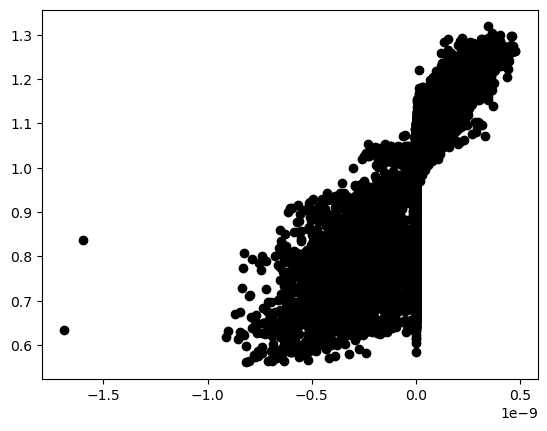

In [7]:
# plot mass growth vs. RH_ice relationship
df_train['mass_diff']=df_train['mass[kg]_2'] - df_train['mass[kg]_1']
plt.scatter(df_train['mass_diff'], df_train['RH_ice_1'], color="black")

Coefficients: 
 [[7.48105249e-10 9.88957221e-01]]
Mean squared error: 0.00
Coefficient of determination: 1.00


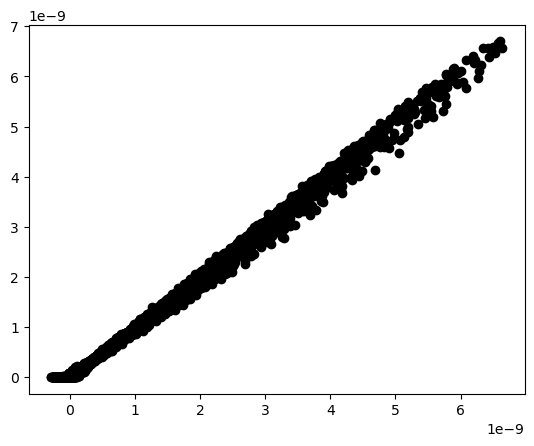

In [8]:
# plot results

# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(y_pred, y_test, color="black")
# plt.plot(X_test, y_pred, color="blue", linewidth=3)

# plt.xticks(())
# plt.yticks(())

plt.show()

### multi-step prediction with single-timestep linear model

i.e., what happens if we predict mass change in a markov chain fashion over multiple time steps into the future?

In [9]:
# get subset for faster training (if needed)
X_train_subset = X_train.sample(50000)
train_idx = X_train_subset.index
y_train_subset = y_train.loc[train_idx]
print(X_train_subset.shape)
print(y_train_subset.shape)

(50000, 2)
(50000, 1)


In [10]:
rf = RandomForestRegressor(n_estimators=100, random_state=666, max_depth=50, 
                           bootstrap=True, criterion='poisson')
# rf.fit(X_train, y_train.values.ravel())
rf.fit(X_train_subset, y_train_subset.values.ravel())
y_pred_rf = rf.predict(X_test)
len(np.unique(y_pred_rf))

50264

Coefficients: 
 [[7.48105249e-10 9.88957221e-01]]
Mean squared error: 0.00
Coefficient of determination: 0.13


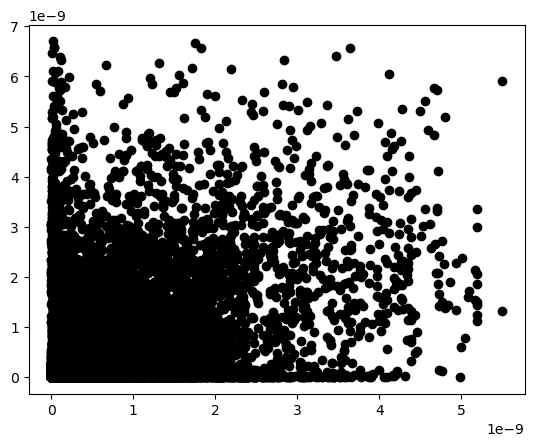

In [11]:
# plot results

# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_rf))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_rf))

# Plot outputs
plt.scatter(y_pred_rf, y_test, color="black")
# plt.plot(X_test, y_pred, color="blue", linewidth=3)

# plt.xticks(())
# plt.yticks(())

plt.show()

Notes on RF:  
- seems to be quite sensitive to hyperparameters
- squared_error and friendmas_mse returns a single value
- poisson and absolute_error return different values
- absolute_error is very slow
- seems to do much worse than linear regression

In [12]:
# # get subset for faster training (if needed)
# X_train_subset = X_train.sample(50000)
# train_idx = X_train_subset.index
# y_train_subset = y_train.loc[train_idx]
# print(X_train_subset.shape)
# print(y_train_subset.shape)

In [13]:
# fit mlp and predict
mlp = MLPRegressor(random_state=666, max_iter=500, 
                   hidden_layer_sizes=(100))
# mlp.fit(X_train, y_train.values.ravel())
# y_pred_mlp = mlp.predict(X_test)
y_scaler = StandardScaler().fit(y_train.values)
pipe = make_pipeline(StandardScaler(), mlp)
# pipe.fit(X_train, y_train.values.ravel())
pipe.fit(X_train, y_scaler.transform(y_train.values).ravel())
y_pred_mlp_scaled = pipe.predict(X_test)
y_pred_mlp = y_scaler.inverse_transform(y_pred_mlp_scaled.reshape(-1, 1))

Coefficients: 
 [[7.48105249e-10 9.88957221e-01]]
Mean squared error: 0.00
Coefficient of determination: 1.00


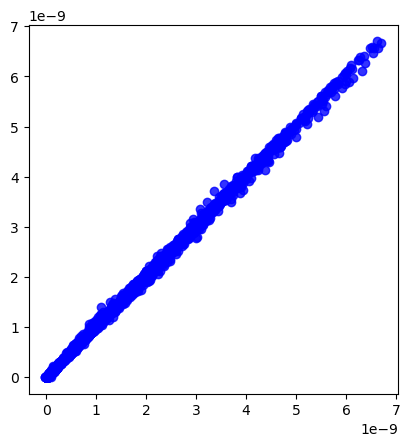

In [14]:
# plot results

# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_mlp))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_mlp))

# Plot outputs
fig, ax = plt.subplots()
plt.scatter(y_pred_mlp, y_test, color="blue", alpha=0.8)
ax.set_box_aspect(1)
plt.show()

# Train NN

In [15]:
# set up data
X_cols = ['RH_ice_1', 'mass[kg]_1', 'radius_eq(ice)[m]_1', 'density(droplet/ice)[kg/m3]_1',
         'rhod [kg/m3]_1', 'prs_1', 'qv_1', 'T [K]_1']
y_cols = ['delta_mass', 'delta_r']
X_train = df_train[X_cols]
y_train = df_train[y_cols]
X_test = df_test[X_cols]
y_test = df_test[y_cols]
# remove suffix from column names
X_train.columns = X_train.columns.str.replace('_1', '')
X_test.columns = X_test.columns.str.replace('_1', '')

In [16]:
# Standardize data
y_scaler = StandardScaler().set_output(transform='pandas').fit(y_train)
X_scaler = StandardScaler().set_output(transform='pandas').fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
y_train_scaled = y_scaler.transform(y_train)
X_test_scaled = X_scaler.transform(X_test)

In [17]:
# fit mlp and predict
mlp = MLPRegressor(random_state=666, max_iter=100, 
                   hidden_layer_sizes=(100, 50, 20),
                   verbose=1)
# mlp.fit(X_train_scaled, y_train_scaled.values.ravel())
mlp.fit(X_train_scaled, y_train_scaled)
y_pred_mlp_scaled = mlp.predict(X_test_scaled)
# y_pred_mlp = y_scaler.inverse_transform(y_pred_mlp_scaled.reshape(-1, 1))
y_pred_mlp = y_scaler.inverse_transform(y_pred_mlp_scaled)

Iteration 1, loss = 0.07809278
Iteration 2, loss = 0.05604428
Iteration 3, loss = 0.05394882
Iteration 4, loss = 0.05224599
Iteration 5, loss = 0.05055909
Iteration 6, loss = 0.04900103
Iteration 7, loss = 0.04801693
Iteration 8, loss = 0.04827076
Iteration 9, loss = 0.04796058
Iteration 10, loss = 0.04771170
Iteration 11, loss = 0.04696732
Iteration 12, loss = 0.04704150
Iteration 13, loss = 0.04683354
Iteration 14, loss = 0.04764780
Iteration 15, loss = 0.04688878
Iteration 16, loss = 0.04663740
Iteration 17, loss = 0.04640291
Iteration 18, loss = 0.04612272
Iteration 19, loss = 0.04703595
Iteration 20, loss = 0.04631870
Iteration 21, loss = 0.04603761
Iteration 22, loss = 0.04598603
Iteration 23, loss = 0.04624904
Iteration 24, loss = 0.04602236
Iteration 25, loss = 0.04589596
Iteration 26, loss = 0.04611451
Iteration 27, loss = 0.04609008
Iteration 28, loss = 0.04583334
Iteration 29, loss = 0.04598018
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. S

Coefficient of determination: 0.95


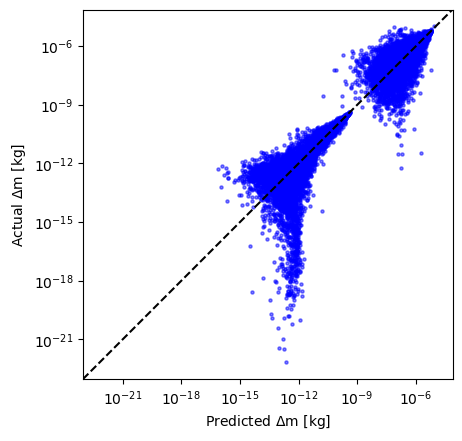

In [18]:
# Plot results for dm
true = y_test['delta_mass']
pred = y_pred_mlp[:, 0]
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(true, pred))
fig, ax = plt.subplots()
plt.scatter(y_pred_mlp, y_test, color="blue", alpha=0.5, s=5.0)
ax.axline((0, 0), slope=1, color='black', linestyle='--')
ax.set_aspect('equal', adjustable='box')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlim(ax.get_ylim()) # set x/y axes limits
plt.xlabel(r'Predicted $\Delta$m [kg]')
plt.ylabel(r'Actual $\Delta$m [kg]')
plt.show()

Coefficient of determination: 0.88


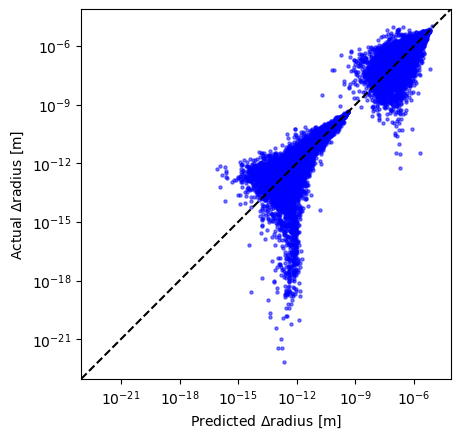

In [19]:
# Plot results for dr
true = y_test['delta_r']
pred = y_pred_mlp[:, 1]
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(true, pred))
fig, ax = plt.subplots()
plt.scatter(y_pred_mlp, y_test, color="blue", alpha=0.5, s=5.0)
ax.axline((0, 0), slope=1, color='black', linestyle='--')
ax.set_aspect('equal', adjustable='box')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlim(ax.get_ylim()) # set x/y axes limits
plt.xlabel(r'Predicted $\Delta$radius [m]')
plt.ylabel(r'Actual $\Delta$radius [m]')
plt.show()

In [20]:
# Save the model to a file
filename = 'nn.pkl'
with open(filename, 'wb') as file:
    pickle.dump(mlp, file)

## Multi-step rollout

In [21]:
# load data
filepath = '/glade/work/psturm/ice-mp-su24/saved_trajectory_data/trajs_5100_7200_Ns10000.csv' # obin's latest csv with combined data
df_multi = pd.read_csv(filepath) # new df used for multi-step prediction (to keep data variable space clean)
sort_cols = ['time', 'rk_deact']
df_multi = df_multi.sort_values(by=sort_cols)
df_multi['volume[m3]'] = (4/3)*np.pi*(df_multi['radius_eq(ice)[m]'])**3
df_multi['mass[kg]'] = df_multi['volume[m3]']*df_multi['density(droplet/ice)[kg/m3]']
cols = ['rk_deact', 'time', 'RH_ice', 'mass[kg]',
        'radius_eq(ice)[m]', 'density(droplet/ice)[kg/m3]',
        'rhod [kg/m3]', 'prs', 'qv', 'T [K]']
df_multi = df_multi[cols]
df_multi = df_multi[df_multi['rk_deact'].isin(ids_test)] # use only training data

# load the model from directory
nn = pickle.load(open('nn.pkl', 'rb'))
print(type(nn))

<class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>


In [22]:
# do multi-step prediction with loaded NN
results = [] # results will be a list of df's
testprint = True # set to True if want to print test statements in loop
timestamps = df_multi.time.unique()
X_cols = ['RH_ice', 'mass[kg]', 'radius_eq(ice)[m]', 'density(droplet/ice)[kg/m3]',
         'rhod [kg/m3]', 'prs', 'qv', 'T [K]']
y_cols = ['delta_mass', 'delta_r']
results_cols = ['time', 'id', 'mass_true', 'mass_pred', 'rad_true', 'rad_pred']
temp_cols = ['time', 'rk_deact', 'mass[kg]', 'mass[kg]', 'radius_eq(ice)[m]', 'radius_eq(ice)[m]']
initial = df_multi[df_multi.time==df_multi.time[0]][temp_cols]
initial.columns = results_cols
results.append(initial)
for i in range(len(timestamps)-1):
    t = timestamps[i]
    t_next = timestamps[i+1]
    x = df_multi[df_multi.time==t][X_cols]
    x_scaled = X_scaler.transform(x)
    y = nn.predict(x_scaled)
    dm = y_scaler.inverse_transform(y)[:, 0]
    dr = y_scaler.inverse_transform(y)[:, 1]
    m_next = x['mass[kg]'].values + dm
    r_next = x['radius_eq(ice)[m]'].values + dr
    result_next = df_multi[df_multi.time==t_next][temp_cols]
    result_next.columns = results_cols
    result_next['mass_pred'] = m_next
    result_next['rad_pred'] = r_next
    results.append(result_next)
    if testprint == True:
        print(f'timestep = {t}')
        print(result_next.head())

timestep = 5100
       time       id     mass_true     mass_pred  rad_true  rad_pred
10642  5160   207674  4.600479e-11  4.563852e-11  0.000033  0.000033
10649  5160   643543  3.457063e-10  3.478754e-10  0.000074  0.000075
17001  5160  1112829  1.726697e-11  1.600207e-11  0.000023  0.000022
10656  5160  1245623  1.585594e-12  2.182980e-12  0.000009  0.000009
13968  5160  2787287  5.738096e-12  5.345793e-12  0.000017  0.000017
timestep = 5160
       time       id     mass_true     mass_pred  rad_true  rad_pred
29583  5220   207674  4.766755e-11  4.722263e-11  0.000034  0.000034
29590  5220   643543  3.449971e-10  3.478475e-10  0.000074  0.000075
29248  5220  1112829  1.801297e-11  1.825401e-11  0.000024  0.000024
29597  5220  1245623  1.130305e-12  1.997283e-12  0.000008  0.000009
27037  5220  2787287  6.145338e-12  5.783249e-12  0.000018  0.000018
timestep = 5220
       time       id     mass_true     mass_pred  rad_true  rad_pred
30133  5280   207674  4.962849e-11  4.926792e-11  0.000

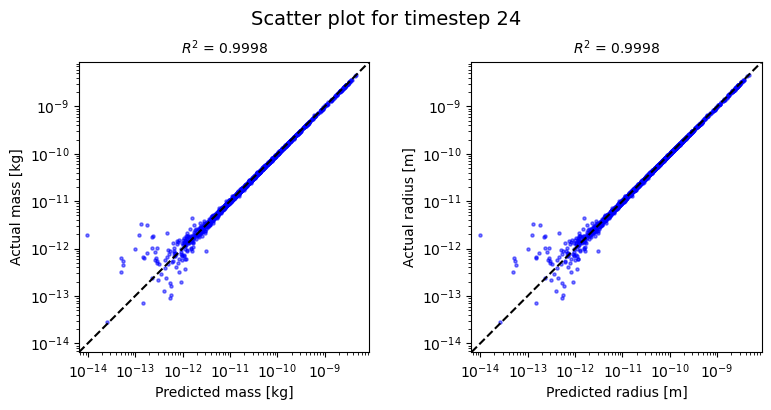

In [23]:
# Plot scatter for mass and radius, for a random timestep
random_timestep = random.randint(0, len(timestamps)-1)
df_temp = results[random_timestep]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
# --- plot for mass ---
true = df_temp['mass_true']
pred = df_temp['mass_pred']
r2 = r2_score(true, pred)
ax1.set_title(f'$R^2$ = {r2:.4f}', fontsize=10)
ax1.scatter(true, pred, color="blue", alpha=0.5, s=5.0)
ax1.axline((0, 0), slope=1, color='black', linestyle='--')
ax1.set_box_aspect(1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(ax1.get_ylim()) # set x/y axes limits
ax1.set_xlabel(r'Predicted mass [kg]')
ax1.set_ylabel(r'Actual mass [kg]')
# --- plot for radius ---
true = df_temp['mass_true']
pred = df_temp['mass_pred']
r2 = r2_score(true, pred)
ax2.set_title(f'$R^2$ = {r2:.4f}', fontsize=10)
ax2.scatter(true, pred, color="blue", alpha=0.5, s=5.0)
ax2.axline((0, 0), slope=1, color='black', linestyle='--')
ax2.set_box_aspect(1)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(ax2.get_ylim()) # set x/y axes limits
ax2.set_xlabel(r'Predicted radius [m]')
ax2.set_ylabel(r'Actual radius [m]')
fig.suptitle(f'Scatter plot for timestep {random_timestep}', fontsize=14)
fig.tight_layout()

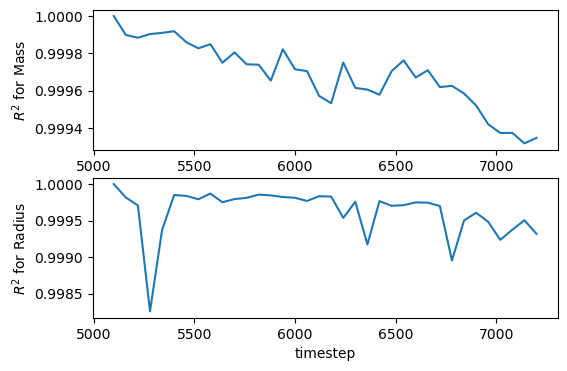

In [24]:
# plot R2 vs. timestep
r2_vals = []
for i in range(len(timestamps)):
    df_temp = results[i]
    mass_true = df_temp['mass_true']
    mass_pred = df_temp['mass_pred']
    mass_r2 = r2_score(mass_true, mass_pred)
    rad_true = df_temp['rad_true']
    rad_pred = df_temp['rad_pred']
    rad_r2 = r2_score(rad_true, rad_pred)
    record = [timestamps[i], mass_r2, rad_r2]
    r2_vals.append(record)
colnames = ['timestep', 'mass_r2', 'rad_r2']
r2_df = pd.DataFrame(r2_vals, columns=colnames)

# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4))
r2_df.plot.line('timestep', 'mass_r2', ax=ax1)
r2_df.plot.line('timestep', 'rad_r2', ax=ax2)
ax1.get_legend().remove()
ax2.get_legend().remove()
ax1.set_ylabel('$R^2$ for Mass')
ax2.set_ylabel('$R^2$ for Radius');